In [1]:
# Import the necessary packages and libraries #
import ee
import folium ; from folium import plugins
import time
import scipy ; from scipy import stats
import sklearn ; from sklearn import linear_model ; from sklearn import preprocessing
import pickle
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import numpy.matlib
import pandas 
import tensorflow
from tensorflow import keras 
import os
from sklearn.neighbors import DistanceMetric
import random

# import custom modules:
import feature_collections as fc
import image_bands as ib
import wrapper_nets as wn
import ee_functions as ee_func

ee.Initialize()

In [2]:
# Sets the precision of the data in the Pandas Dataframes 

pandas.set_option("precision", 10)

In [3]:
# Removes any Tensorflow warnings 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# -----------------------------------
# INPUT PARAMETERS / SETUP: TO MODIFY
# -----------------------------------
outputName = 'LAI'
    # product name, one of: 'Surface_Reflectance','Albedo','fAPAR','fCOVER','LAI','CCC','CWC','DASF'

siteSelect = 'Geraldton'
    # site selection, one of: 'Ottawa', 'Geraldton', 'FoxCreek', 'Kouchibouguac'


# output parameters, outputScale and outputOffset not applied to "Surface_Reflectance"
outputParams = {
    'Surface_Reflectance': {
        'outputScale': 0,
        'outputOffset': 0,
        'outputMax': 0
    },
    'Albedo': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 0.2
    },
    'fAPAR': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'fCOVER': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'LAI': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 8
    },
    'CCC': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 6
    },
    'CWC': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 0.55
    },
    'DASF': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    }
}

outputScale = outputParams[outputName]['outputScale']
outputOffset = outputParams[outputName]['outputOffset']
outputMax = outputParams[outputName]['outputMax']


# specify parameters based on siteSelect: default image (Ottawa region), or one of three test sites:
siteParams = {
    # default region
    'Ottawa': {
        'inputImage': None,
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-75, 45], \
                          [-75, 46], \
                          [-74, 46], \
                          [-74, 45]]])
    },
    # Geraldton, ON
    'Geraldton': {
        'inputImage': ee.Image('COPERNICUS/S2_SR/20200811T164849_20200811T165525_T16UEA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-86, 49.5], \
                          [-86, 50], \
                          [-85.5, 50], \
                          [-85.5, 49.5]]])
    },
    # Fox Creek, AB
    'FoxCreek': {
        'inputImage': ee.Image('COPERNICUS/S2_SR/20210825T185919_20210825T190431_T11UNA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-117, 54], \
                          [-117, 55], \
                          [-115, 55], \
                          [-115, 54]]])
    },
    # Kouchibouguac, NB
    'Kouchibouguac': {
        'inputImage': ee.Image('COPERNICUS/S2_SR/20200905T151701_20200905T151829_T20TLS'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-65, 46], \
                          [-65, 47], \
                          [-64, 47], \
                          [-64, 46]]])
    }
}

mapBounds = siteParams[siteSelect]['mapBounds']
inputImage = siteParams[siteSelect]['inputImage']


# other filters (date filters apply to default region only)
maxCloudcover = 10
startDate = ee.Date('2020-08-01'),
endDate = ee.Date('2020-08-5')

# export parameters
exportFolder = siteSelect+'_'+outputName
exportScale = 20
exportDatatype = "int"

In [5]:
COLLECTION_OPTIONS = {
    # Sentinel 2 using 20 m bands:
    'COPERNICUS/S2_SR': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    # Sentinel 2 using 10 m bands:
    'COPERNICUS/S2_SR_10m': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    'LANDSAT/LC08/C01/T1_SR': {
      "name": 'LANDSAT/LC08/C01/T1_SR',
      "description": 'LANDSAT 8',
      "Cloudcover": 'CLOUD_COVER_LAND',
      "Watercover": 'CLOUD_COVER',
      "sza": 'SOLAR_ZENITH_ANGLE',
      "vza": 'SOLAR_ZENITH_ANGLE',
      "saa": 'SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'SOLAR_AZIMUTH_ANGLE',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.l8_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.l8_createFeatureCollection_errors()),
      "sl2pDomain": ee.FeatureCollection(fc.l8_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.l8_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.l8_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.l8_createFeatureCollection_legend()),
      "numVariables": 7
    }
}

VIS_OPTIONS = {
    'Surface_Reflectance': {
        "COPERNICUS/S2_SR": {
            "Name": 'Surface_Reflectance',
            "description": 'Surface_Reflectance',
            "inp": ['B4', 'B5', 'B6', 'B7', 'B8A', 'B9', 'B11', 'B12']
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'Surface_Reflectance',
            "description": 'Surface_Reflectance',
            "inp": ['B2', 'B3', 'B4', 'B8']
        }
    },
    'Albedo': {
        "COPERNICUS/S2_SR": {
            "Name": 'Albedo',
            "errorName": 'errorAlbedo',
            "maskName": 'maskAlbedo',
            "description": 'Black sky albedo',
            "variable": 6,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'Albedo',
            "errorName": 'errorAlbedo',
            "maskName": 'maskAlbedo',
            "description": 'Black sky albedo',
            "variable": 6,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'CCC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CCC',
            "errorName": 'errorCCC',
            "maskName": 'maskCCC',
            "description": 'Canopy chlorophyll content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1000]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'CCC',
            "errorName": 'errorCCC',
            "maskName": 'maskCCC',
            "description": 'Canopy chlorophyll content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1000]])))
        }
    },
    'CWC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CWC',
            "errorName": 'errorCWC',
            "maskName": 'maskCWC',
            "description": 'Canopy water content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[100]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'CWC',
            "errorName": 'errorCWC',
            "maskName": 'maskCWC',
            "description": 'Canopy water content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[100]])))
        }
    },
    'DASF': {
        "COPERNICUS/S2_SR": {
            "Name": 'DASF',
            "errorName": 'errorDASF',
            "maskName": 'maskDASF',
            "description": 'Directional area scattering factor',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'DASF',
            "errorName": 'errorDASF',
            "maskName": 'maskDASF',
            "description": 'Directional area scattering factor',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    }
}

In [6]:
# parse the networks
colName = 'COPERNICUS/S2_SR'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

### Original SL2P:

In [7]:
# filter collection and add ancillary bands
if siteSelect == 'Ottawa':
    input_collection = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                         .filterBounds(mapBounds) \
                         .filterDate(startDate, endDate) \
                         .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                         .limit(5000) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.s2MaskLand(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image))

else:
    input_collection = ee.ImageCollection(inputImage) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.s2MaskLand(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image))


if outputName == "Surface_Reflectance":
    export_collection = input_collection
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')
    
    # pre process input imagery and flag invalid inputs
    scaled_input_collection = input_collection.map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                       .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
    uncertaintySL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))
    
    # scale and offset mapped parameter bands
    estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))
    uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))
    
    # produce final export collection
    export_collection = input_collection.combine(estimateSL2P).combine(uncertaintySL2P)
    
image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

### SL2P10_20m and SL2P10_10m:

In [8]:
# parse the networks
colName = 'COPERNICUS/S2_SR_10m'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [9]:
# performs same procedure as above block using SL2P10 network
# reduces image resolution before applying algorithm
    
# filter collection and add ancillary bands
if siteSelect == 'Ottawa':
    input_collection_20m = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                         .filterBounds(mapBounds) \
                         .filterDate(startDate, endDate) \
                         .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                         .limit(5000) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image)) \
                         .map(lambda image: ib.reduceTo20m(image))

else:
    input_collection_20m = ee.ImageCollection(inputImage) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.s2MaskLand(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image)) \
                         .map(lambda image: ib.reduceTo20m(image))


if outputName == "Surface_Reflectance":
    export_collection_20m = input_collection_20m
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

    # pre process input imagery and flag invalid inputs
    input_collection_20m = input_collection_20m.map(lambda image: ib.s2MaskLand(image)) \
                                               .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                               .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P_20m = input_collection_20m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
    uncertaintySL2P_20m = input_collection_20m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

    # scale and offset mapped parameter bands
    estimateSL2P_20m = estimateSL2P_20m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                               .multiply(ee.Image.constant(outputScale)) \
                                                               .add(ee.Image.constant(outputOffset)), overwrite = True))
    uncertaintySL2P_20m = uncertaintySL2P_20m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                     .multiply(ee.Image.constant(outputScale)) \
                                                                     .add(ee.Image.constant(outputOffset)),overwrite = True))
    
    # produce final export collection
    export_collection_20m = input_collection_20m.combine(estimateSL2P_20m).combine(uncertaintySL2P_20m)

image_output_names_20m = ([name+"_"+outputName+"_20m" for name in export_collection_20m.toList(export_collection_20m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection_20m.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

In [10]:
# performs same procedure as above block using SL2P10 network
# applies algorithm to 10 m bands ; generates a 10 m map

# filter collection and add ancillary bands
if siteSelect == 'Ottawa':
    input_collection_10m = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                         .filterBounds(mapBounds) \
                         .filterDate(startDate, endDate) \
                         .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                         .limit(5000) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image))

else:
    input_collection_10m = ee.ImageCollection(inputImage) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.s2MaskLand(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image))

if outputName == "Surface_Reflectance":
    export_collection_10m = input_collection_10m
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')
    
    # pre process input imagery and flag invalid inputs
    input_collection_10m = input_collection_10m.map(lambda image: ib.s2MaskLand(image)) \
                                               .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                               .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P_10m = input_collection_10m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
    uncertaintySL2P_10m = input_collection_10m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))
    
    # scale and offset mapped parameter bands
    estimateSL2P_10m = estimateSL2P_10m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                                 .multiply(ee.Image.constant(outputScale)) \
                                                                 .add(ee.Image.constant(outputOffset)), overwrite = True));
    uncertaintySL2P_10m = uncertaintySL2P_10m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                       .multiply(ee.Image.constant(outputScale)) \
                                                                       .add(ee.Image.constant(outputOffset)),overwrite = True));
    
    
    # produce final export collection
    export_collection_10m = input_collection_10m.combine(estimateSL2P_10m).combine(uncertaintySL2P_10m)

image_output_names_10m = ([name+"_"+outputName+"_10m" for name in export_collection_10m.toList(export_collection_10m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection_10m.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

In [11]:
# combine all SL2P, SL2P10_10m, SL2P10_20m bands into a single image to sample corresponding pixel values

export_20m = export_collection_20m.first()
export_10m = export_collection_10m.first()

export_20m = export_20m.select('estimate'+outputName).rename('estimate'+outputName+'_20m')
export_10m = export_10m.select('estimate'+outputName).rename('estimate'+outputName+'_10m')

# get the first image in export_collection ; add all bands from corresponding image in export_collection_10m and export_collection_10m
full_image = export_collection.first().addBands(export_20m)

# sample the composed image with SL2P10_10m and SL2P10_20m bands
samples = full_image.select('estimate'+outputName).sample(numPixels=5000, projection=export_collection.first().select('estimate'+outputName)\
                                                             .projection(), scale=20).getInfo()

band_data = full_image.select(['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']).sample(numPixels=5000, projection=export_collection.first().select('estimate'+outputName)\
                                                             .projection(), scale=20).getInfo()

#print(band_data)

bands = ['B3','B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12','cosVZA', 'cosSZA', 'cosRAA']

list_length = len(samples['features'])
estimate_list = []

# populate an array with the estimate for SL2P, SL2P10_10m, SL2P10_20m
for i in range(list_length):
    temp_list = []
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName])
    estimate_list.append(temp_list)

band_array = numpy.empty((list_length,len(bands))) 

print(band_data['features'][0]['properties'])

for idx, band in enumerate(bands):
    for j in range(list_length):
        band_array[j,idx] = band_data['features'][j]['properties'][band]
    

estimate_array = pandas.DataFrame(estimate_list).rename(columns={0:'estimate'+outputName})

{'B11': 879, 'B12': 399, 'B3': 275, 'B4': 153, 'B5': 442, 'B6': 1746, 'B7': 2158, 'B8A': 2348, 'cosRAA': 10000, 'cosSZA': 8034, 'cosVZA': 10000}


In [12]:
bands_df = pandas.DataFrame(data=band_array, columns = bands)

In [13]:
bands_df = bands_df.divide(10000)

bands_df

,B3,B4,B5,B6,B7,B8A,B11,B12,cosVZA,cosSZA,cosRAA
0,0.0275,0.0153,0.0442,0.1746,0.2158,0.2348,0.0879,0.0399,1.0,0.8034,1.0
1,0.0380,0.0226,0.0672,0.2048,0.2573,0.2761,0.1377,0.0692,1.0,0.8034,1.0
2,0.0455,0.0228,0.0824,0.2194,0.2494,0.2727,0.1479,0.0749,1.0,0.8034,1.0
3,0.0348,0.0169,0.0564,0.1649,0.2008,0.2245,0.1082,0.0564,1.0,0.8034,1.0
4,0.0297,0.0162,0.0464,0.1672,0.2059,0.2174,0.0862,0.0417,1.0,0.8034,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4767,0.0416,0.0218,0.0667,0.1745,0.1987,0.2185,0.1199,0.0611,1.0,0.8034,1.0
4768,0.0464,0.0384,0.0573,0.1331,0.1528,0.1668,0.1048,0.0571,1.0,0.8034,1.0
4769,0.0367,0.0201,0.0585,0.2187,0.2729,0.2992,0.1253,0.0560,1.0,0.8034,1.0
4770,0.0329,0.0159,0.0548,0.2081,0.2439,0.2618,0.1010,0.0459,1.0,0.8034,1.0


In [14]:
bands_df_scaled = pandas.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(bands_df), columns = bands)

bands_df_scaled

,B3,B4,B5,B6,B7,B8A,B11,B12,cosVZA,cosSZA,cosRAA
0,-0.8595501793,-0.5931335068,-1.0125607993,-0.3410220025,-0.2598580403,-0.2420944784,-1.0439751117,-1.0378481731,0.0,1.0,0.0
1,0.2311066740,0.1471300220,0.3627434503,0.2552407384,0.3786277926,0.3510295151,0.4631194110,0.5138711625,0.0,1.0,0.0
2,1.0101472835,0.1674112146,1.2716401718,0.5435002092,0.2570847063,0.3022009055,0.7718014216,0.8157414770,0.0,1.0,0.0
3,-0.1012839860,-0.4308839663,-0.2830515886,-0.5325368564,-0.4906360521,-0.3900164429,-0.4296373846,-0.1640130523,0.0,1.0,0.0
4,-0.6310316005,-0.5018681403,-0.8810099580,-0.4871261179,-0.4121715281,-0.4919820689,-1.0954221135,-0.9425207054,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4767,0.6050461666,0.0660052517,0.3328455318,-0.3429963825,-0.5229449738,-0.4761845776,-0.0755609606,0.0848975578,0.0,1.0,0.0
4768,1.1036321566,1.7493442351,-0.2292353354,-1.1603896763,-1.2291256901,-1.2186666712,-0.5325313882,-0.1269412593,0.0,1.0,0.0
4769,0.0960729684,-0.1063848851,-0.1574803311,0.5296795496,0.6186369249,0.6827768335,0.0878589274,-0.1851969341,0.0,1.0,0.0
4770,-0.2986409404,-0.5322899291,-0.3787249278,0.3203952763,0.1724661020,0.1456621275,-0.6475305686,-0.7200899474,0.0,1.0,0.0


In [15]:
bands_df_scaled['cosVZA'] = numpy.random.uniform(-2.2, 1.3, size = 4772)
bands_df_scaled['cosSZA'] = numpy.random.uniform(-2.5, 1.4, size = 4772)
bands_df_scaled['cosRAA'] = numpy.random.uniform(-1.4, 1.3, size = 4772)

In [16]:
bands_df_scaled

,B3,B4,B5,B6,B7,B8A,B11,B12,cosVZA,cosSZA,cosRAA
0,-0.8595501793,-0.5931335068,-1.0125607993,-0.3410220025,-0.2598580403,-0.2420944784,-1.0439751117,-1.0378481731,0.4649866725,-2.2759119310,0.0143115339
1,0.2311066740,0.1471300220,0.3627434503,0.2552407384,0.3786277926,0.3510295151,0.4631194110,0.5138711625,0.0189989591,0.2298117576,-0.9422073016
2,1.0101472835,0.1674112146,1.2716401718,0.5435002092,0.2570847063,0.3022009055,0.7718014216,0.8157414770,-1.0349222018,1.3833656283,-0.8709680639
3,-0.1012839860,-0.4308839663,-0.2830515886,-0.5325368564,-0.4906360521,-0.3900164429,-0.4296373846,-0.1640130523,1.1182272891,-0.2199214253,-1.2516427064
4,-0.6310316005,-0.5018681403,-0.8810099580,-0.4871261179,-0.4121715281,-0.4919820689,-1.0954221135,-0.9425207054,0.1618322706,-0.6810134941,-0.7940759373
...,...,...,...,...,...,...,...,...,...,...,...
4767,0.6050461666,0.0660052517,0.3328455318,-0.3429963825,-0.5229449738,-0.4761845776,-0.0755609606,0.0848975578,-1.5654095474,-0.4569316956,-0.5957244621
4768,1.1036321566,1.7493442351,-0.2292353354,-1.1603896763,-1.2291256901,-1.2186666712,-0.5325313882,-0.1269412593,-0.0849974005,-1.7639572026,-0.5936839004
4769,0.0960729684,-0.1063848851,-0.1574803311,0.5296795496,0.6186369249,0.6827768335,0.0878589274,-0.1851969341,-2.1927551473,-0.3013136506,-1.3013782040
4770,-0.2986409404,-0.5322899291,-0.3787249278,0.3203952763,0.1724661020,0.1456621275,-0.6475305686,-0.7200899474,1.1148292517,-2.1306218555,-1.1464649288


In [17]:
sl2p = estimate_array['estimate'+outputName]/outputScale

sl2p

0       2.7680812060
1       2.5067843844
2       2.1278628500
3       2.3537308986
4       2.5778065303
            ...     
4767    1.9928837789
4768    1.5421508664
4769    2.9135863348
4770    2.7096262119
4771    2.6006841466
Name: estimateLAI, Length: 4772, dtype: float64

In [18]:
sl2p_scaled = (sl2p-sl2p.mean())/sl2p.std()

In [19]:
# Load the model 

LAI_model = keras.models.load_model('./models/LAI_models')

In [20]:
# Apply the Neural network

LAI_image_predicted = pandas.Series(LAI_model.predict(numpy.array(bands_df_scaled)).flatten())

In [21]:
# Function that creates a density plot

def plotting_function(var, input_var, resp_var, title, xlabel, ylabel, alg, ax=None):
    ax = ax
    xy = numpy.vstack([input_var, resp_var])
    z = scipy.stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x = input_var[idx]
    y = resp_var[idx]
    z = z[idx]
    rmse = sklearn.metrics.mean_squared_error(x, y, squared=False)
    r_sqr = sklearn.metrics.r2_score(x, y)
    ax.scatter(x, y, c = z)
    plt.colorbar(mappable=ax.scatter(x, y, c = z), ax=ax)
    ax.set_title(title + '-' + alg + ' - RMSE: {}'.format(rmse) + ' - $R^2$: {}'.format(r_sqr))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

Text(0.5, 0.98, 'SL2P vs NNet')

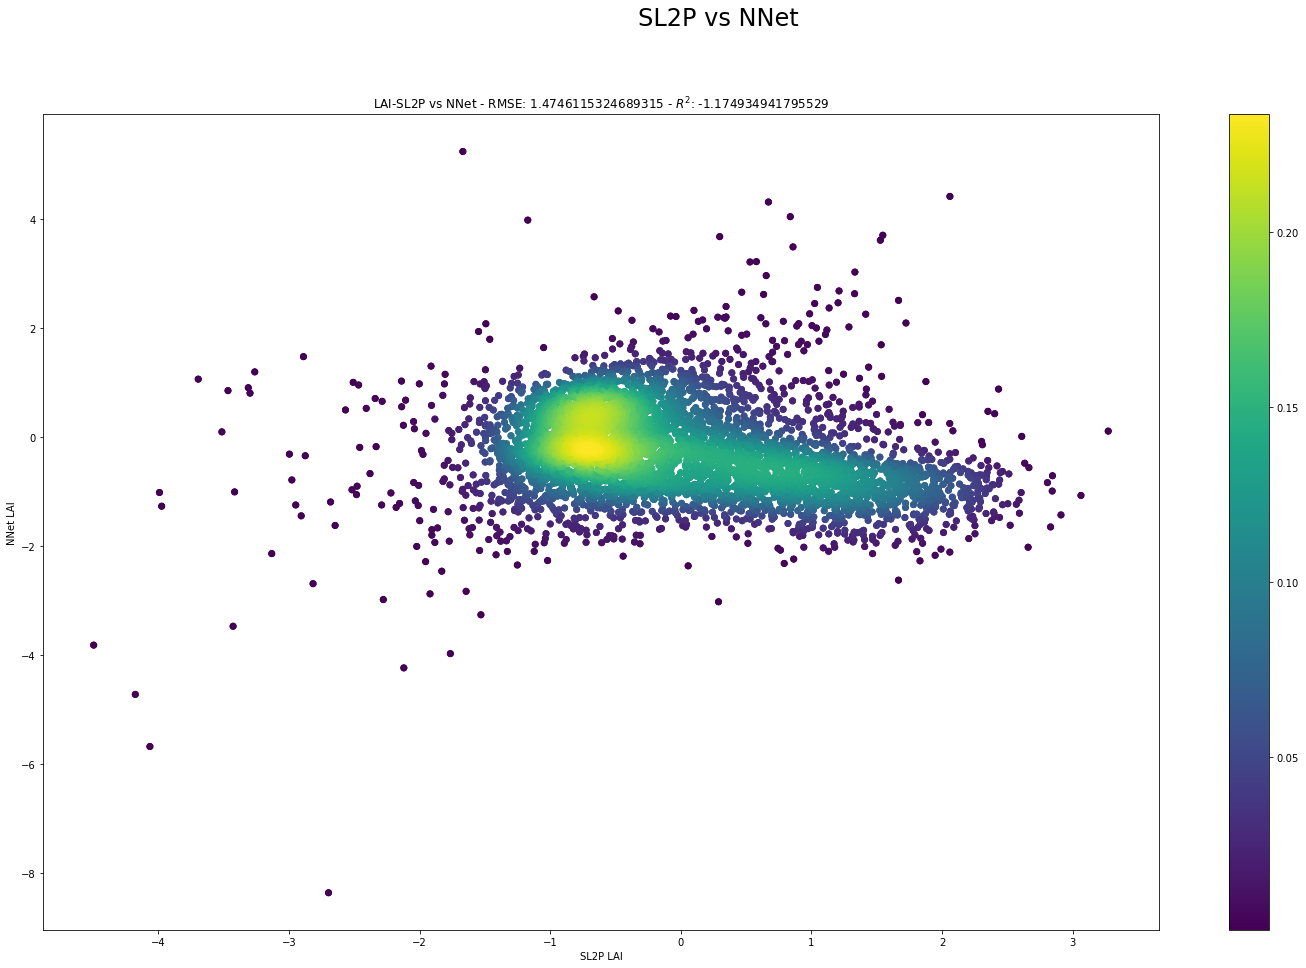

In [22]:
fig, (ax1) = plt.subplots(1,1,figsize=(25,15))

plotting_function('LAI', sl2p_scaled, LAI_image_predicted, 'LAI','SL2P LAI','NNet LAI','SL2P vs NNet', ax1)
  
fig.suptitle('SL2P vs NNet', fontsize=24)